In [7]:
%pip install -U "transformers>=4.55.2" "huggingface_hub>=0.34.0" "open-clip-torch>=2.26.1" "git+https://github.com/openai/CLIP.git" "git+https://github.com/facebookresearch/sam2.git"


  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ixq5y768
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ixq5y768
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-v5lud0kh
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-v5lud0kh
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached transformers-4.55.2-py3-none-any.whl.metadata (41 kB)
  Using cached huggingface_hub-0.34.4-py3-none-any.whl.metadata (14 kB)
Using cached transformers-4.55.2-py3-none-any.whl (11.3 MB)
Using cache

In [ ]:
!pip list | grep tran

s3transfer                 0.13.0
transformers               4.55.2


In [ ]:
# Compatibility shim for Ultralytics expecting clip.clip.tokenize
# Ensures that either open_clip or openai-clip exposes clip.clip.tokenize
try:
    import clip as openai_clip
except Exception:
    openai_clip = None

try:
    import open_clip
except Exception:
    open_clip = None

class _CompatClipModule:
    class clip:
        @staticmethod
        def tokenize(text):
            # Prefer OpenAI CLIP if available
            if openai_clip is not None and hasattr(openai_clip, 'tokenize'):
                return openai_clip.tokenize(text)
            # Fallback to OpenCLIP tokenizer
            if open_clip is not None:
                return open_clip.tokenize(text)
            raise ImportError("No CLIP tokenizer available. Install 'openai-clip' or 'open-clip-torch'.")

# If module named 'clip' exists but lacks 'clip' attribute, monkey-patch
import types, sys
if 'clip' in sys.modules:
    mod = sys.modules['clip']
    if not hasattr(mod, 'clip'):
        mod.clip = _CompatClipModule.clip
else:
    sys.modules['clip'] = types.SimpleNamespace(clip=_CompatClipModule.clip)

print("CLIP compatibility shim loaded.")


CLIP compatibility shim loaded.



image 1/1 /purestorage/AILAB/AI_1/tyk/3_CUProjects/VLMs/exercises/qwen25vl/assets/universal_recognition/unireco_birds_example.jpg: 480x640 4 birds, 17.7ms
Speed: 2.6ms preprocess, 17.7ms inference, 54.7ms postprocess per image at shape (1, 3, 480, 640)


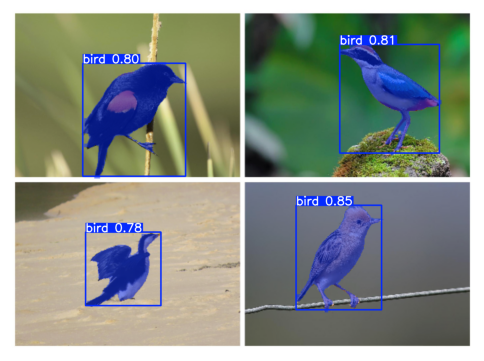

In [ ]:
from ultralytics import YOLOE
import matplotlib.pyplot as plt

# Initialize a YOLOE model
model = YOLOE("yoloe-11l-seg.pt")

# Set text prompt to detect bird(s)
names = ["bird"]
model.set_classes(names, model.get_text_pe(names))

image_path = "/purestorage/AILAB/AI_1/tyk/3_CUProjects/VLMs/exercises/qwen25vl/assets/universal_recognition/unireco_birds_example.jpg"
results = model.predict(image_path, conf=0.15)

# Inline display instead of external viewer
annotated = results[0].plot()  # BGR ndarray
plt.figure(figsize=(6, 6))
plt.imshow(annotated[..., ::-1])
plt.axis("off")
plt.show()

In [13]:
type(results[0])

ultralytics.engine.results.Results

In [14]:
results[1]

IndexError: list index out of range

In [ ]:
import torch
import numpy as np
from sam2.sam2_image_predictor import SAM2ImagePredictor
from PIL import Image

pil_image = Image.open('/purestorage/AILAB/AI_1/tyk/3_CUProjects/VLMs/exercises/qwen25vl/assets/universal_recognition/unireco_birds_example.jpg')
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

use_cuda = torch.cuda.is_available()

# SAM2 expects numpy arrays: point_coords (N, 2), point_labels (N,)
point_coords = np.array([[200.0, 200.0]], dtype=np.float32)
point_labels = np.array([1], dtype=np.int32)

with torch.inference_mode():
    predictor.set_image(pil_image)
    if use_cuda:
        with torch.autocast("cuda", dtype=torch.bfloat16):
            masks, _, _ = predictor.predict(
                point_coords=point_coords,
                point_labels=point_labels,
                multimask_output=False,
            )
    else:
        masks, _, _ = predictor.predict(
            point_coords=point_coords,
            point_labels=point_labels,
            multimask_output=False,
        )

masks.shape


AssertionError: point_labels must be supplied if point_coords is supplied.

In [ ]:
from transformers import Sam2VideoModel, Sam2VideoProcessor
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.bfloat16 if device == "cuda" else torch.float32
model = Sam2VideoModel.from_pretrained("facebook/sam2-hiera-large").to(device, dtype=dtype)
processor = Sam2VideoProcessor.from_pretrained("facebook/sam2-hiera-large")

# Load video frames (example assumes you have a list of PIL Images)
# video_frames = [Image.open(f"frame_{i:05d}.jpg") for i in range(num_frames)]

# For this example, we'll use the video loading utility
from transformers.video_utils import load_video
video_url = "https://huggingface.co/datasets/hf-internal-testing/sam2-fixtures/resolve/main/bedroom.mp4"
video_frames, _ = load_video(video_url)

# Initialize video inference session
inference_session = processor.init_video_session(
    video=video_frames,
    inference_device=device,
    torch_dtype=dtype,
)

# Add click on first frame to select object
ann_frame_idx = 0
ann_obj_id = 1
points = [[[[210, 350]]]]
labels = [[[1]]]

processor.add_inputs_to_inference_session(
    inference_session=inference_session,
    frame_idx=ann_frame_idx,
    obj_ids=ann_obj_id,
    input_points=points,
    input_labels=labels,
)

# Segment the object on the first frame
outputs = model(
    inference_session=inference_session,
    frame_idx=ann_frame_idx,
)
video_res_masks = processor.post_process_masks(
    [outputs.pred_masks], original_sizes=[[inference_session.video_height, inference_session.video_width]], binarize=False
)[0]
print(f"Segmentation shape: {video_res_masks.shape}")

# Propagate through the entire video
video_segments = {}
for sam2_video_output in model.propagate_in_video_iterator(inference_session):
    video_res_masks = processor.post_process_masks(
        [sam2_video_output.pred_masks], original_sizes=[[inference_session.video_height, inference_session.video_width]], binarize=False
    )[0]
    video_segments[sam2_video_output.frame_idx] = video_res_masks

print(f"Tracked object through {len(video_segments)} frames")


ImportError: cannot import name 'Sam2VideoModel' from 'transformers' (/opt/conda/lib/python3.11/site-packages/transformers/__init__.py)

In [ ]:
!python -c "import transformers; print('transformers:', transformers.__version__)"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.5/561.5 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.32.4
    Uninstalling huggingface-hub-0.32.4:
      Successfully uninstalled huggingface-hub-0.32.4
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.1
    Uninstalling transformers-4.53.1:
      Successfully uninstalled transformers-4.53.1
